# 필수 실행


## 구글드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 필수 임포트

In [ ]:
import os
import random
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import matplotlib.font_manager as fm
import tqdm
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

pd.set_option('display.max_columns', None)

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42)

import warnings
warnings.filterwarnings('ignore')

## csv파일 불러오기


In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/daegu/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/daegu/test.csv')
submission_df = pd.read_csv('/content/drive/MyDrive/daegu/sample_submission.csv')
extra_train_df = pd.read_csv('/content/drive/MyDrive/daegu/external_open/countrywide_accident.csv')
light_df = pd.read_csv('/content/drive/MyDrive/daegu/external_open/대구보안등정보.csv',encoding='cp949')
child_area_df = pd.read_csv('/content/drive/MyDrive/daegu/external_open/대구어린이보호구역정보.csv',encoding='cp949')
parking_df = pd.read_csv('/content/drive/MyDrive/daegu/external_open/대구주차장정보.csv',encoding='cp949')
cctv_df = pd.read_csv('/content/drive/MyDrive/daegu/external_open/대구CCTV정보.csv',encoding='cp949')

- '사고일시' 분리

In [ ]:
time_pattern = r'(\d{4})-(\d{1,2})-(\d{1,2}) (\d{1,2})'

train_df[['연', '월', '일', '시간']] = train_df['사고일시'].str.extract(time_pattern)
train_df[['연', '월', '일', '시간']] = train_df[['연', '월', '일', '시간']].apply(pd.to_numeric)
train_df = train_df.drop(columns=['사고일시'])

test_df[['연', '월', '일', '시간']] = test_df['사고일시'].str.extract(time_pattern)
test_df[['연', '월', '일', '시간']] = test_df[['연', '월', '일', '시간']].apply(pd.to_numeric)
test_df = test_df.drop(columns=['사고일시'])

- '시군구' 분리

In [ ]:
location_pattern = r'(\S+) (\S+) (\S+)'

train_df[['도시', '구', '동']] = train_df['시군구'].str.extract(location_pattern)
train_df = train_df.drop(columns=['시군구'])

test_df[['도시', '구', '동']] = test_df['시군구'].str.extract(location_pattern)
test_df = test_df.drop(columns=['시군구'])

# Model_1 [0.42862]


In [ ]:
test_x = test_df[['요일', '노면상태', '사고유형', '도로형태', '연','월','일','시간']].copy()
train_x = train_df[['요일', '노면상태', '사고유형', '도로형태', '연','월','일','시간']].copy()
train_y = train_df['ECLO'].copy()

In [ ]:
def one_hot(df):

    # one-hot encoding 실시
    df = pd.get_dummies(df)

    return df

In [ ]:
X_train_eng = one_hot(train_x)
X_test_eng = one_hot(test_x)

# target값 로그치환
y_train = np.log(train_y)

In [ ]:
print(f'X_train 데이터 shape : {X_train_eng.shape}')
print(f'y_train 데이터 shape : {y_train.shape}')
print()
print(f'X_test 데이터 shape : {X_test_eng.shape}')

X_train 데이터 shape : (39609, 31)
y_train 데이터 shape : (39609,)

X_test 데이터 shape : (10963, 31)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train_eng, y_train , test_size=0.2, random_state=42)

In [ ]:
import numpy as np

def rmsle(y_true, y_pred):
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

from sklearn.metrics import make_scorer

# RMSLE를 평가 지표로 변환
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

## LGBMRegressor 모델

In [ ]:
from lightgbm.sklearn import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
# LGBM Regressor 모델 생성
lgbm = LGBMRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'num_leaves': [10, 20, 30],
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [300, 400, 500, 800, 1200]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_lgbm = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_lgbm.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_lgbm.best_params_)
print("최적의 점수:", grid_search_lgbm.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
lgbm_best = LGBMRegressor(**grid_search_lgbm.best_params_,random_state=42)

# 모델 학습
lgbm_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = lgbm_best.predict(X_train)
y_val_pred = lgbm_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 119
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 27
[LightGBM] [Info] Start training from score 1.383856
최적의 하이퍼파라미터: {'learning_rate': 0.01, 'n_estimators': 400, 'num_leaves': 10}
최적의 점수: 0.029031155269384157
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004938 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 119
[LightGBM] [Info] Number of data points in the train set: 31687, number

## RandomForestRegressor 모델

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
# Random Forest Regressor 모델 생성
rf = RandomForestRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [8, 10, 12]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_rf.best_params_)
print("최적의 점수:", grid_search_rf.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
rf_best = RandomForestRegressor(**grid_search_rf.best_params_,random_state=42)

# 모델 학습
rf_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = rf_best.predict(X_train)
y_val_pred = rf_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

최적의 하이퍼파라미터: {'max_depth': 10, 'min_samples_split': 12, 'n_estimators': 300}
최적의 점수: 0.022340582021947553
0.4315169946839741
0.4481976925060826


## XGBRegressor 모델

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_regression

In [ ]:
# XGB Regressor 모델 생성
xgb = XGBRegressor(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [300, 400, 500],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.001, 0.01, 0.1]
}

# GridSearchCV를 사용하여 그리드 탐색 실행
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 점수 출력
print("최적의 하이퍼파라미터:", grid_search_xgb.best_params_)
print("최적의 점수:", grid_search_xgb.best_score_)

# 최적의 하이퍼파라미터를 적용하여 모델 생성
xgb_best = XGBRegressor(**grid_search_xgb.best_params_,random_state=42)

# 모델 학습
xgb_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = xgb_best.predict(X_train)
y_val_pred = xgb_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

최적의 하이퍼파라미터: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
최적의 점수: 0.028918976438860582
0.44493776835246157
0.4470742535218405


## GradientBoosting

In [ ]:
from sklearn.datasets import make_regression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
model = GradientBoostingRegressor()

# 탐색할 하이퍼파라미터 그리드 정의
param_grid = {
    'n_estimators': [50, 100, 150],  # 트리 개수
    'learning_rate': [0.01, 0.1, 0.2],  # 학습률
    'max_depth': [3, 4, 5]  # 트리 최대 깊이
}

# GridSearchCV를 사용하여 하이퍼파라미터 탐색
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

gb_best = grid_search.best_estimator_

gb_best.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = gb_best.predict(X_train)
y_val_pred = gb_best.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

0.4448149797002048
0.4471686491821946


## Stack

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression

In [ ]:
# 개별 모델 생성
rf = rf_best
lgbm = lgbm_best
xgb = xgb_best
gb = gb_best


# 스태킹 앙상블 모델 생성
estimators = [
    ('rf', rf),
    ('lgbm', lgbm),
    ('xgb', xgb),
    ('gb', gb)
]
stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression()
)

# 모델 학습
stacking_model.fit(X_train, y_train)

# 테스트 데이터로 예측
y_train_pred = stacking_model.predict(X_train)
y_val_pred = stacking_model.predict(X_val)

y_train_pred1 = np.exp(y_train_pred)
y_val_pred1 = np.exp(y_val_pred)

y_train1 = np.exp(y_train)
y_val1 = np.exp(y_val)

print(rmsle(y_train1, y_train_pred1))
print(rmsle(y_val1, y_val_pred1))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 119
[LightGBM] [Info] Number of data points in the train set: 31687, number of used features: 27
[LightGBM] [Info] Start training from score 1.383856
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002881 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 119
[LightGBM] [Info] Number of data points in the train set: 25349, number of used features: 27
[LightGBM] [Info] Start training from score 1.386939
[LightGBM] [Warning] Found whi

In [ ]:
# 예측하기
y_pred1 = stacking_model.predict(X_test_eng)
y_pred1

array([1.29953129, 1.1916106 , 1.5309443 , ..., 1.37940378, 1.38258827,
       1.43195649])

In [ ]:
# 로그치환한거 풀어주기
y_pred = np.exp(y_pred1)
y_pred

array([3.66757724, 3.29237964, 4.62253983, ..., 3.97253243, 3.98520307,
       4.1868828 ])

In [ ]:
submission_df['ECLO'] = y_pred
submission_df.head()

,ID,ECLO
0,ACCIDENT_39609,3.667577
1,ACCIDENT_39610,3.292380
2,ACCIDENT_39611,4.622540
3,ACCIDENT_39612,4.389425
4,ACCIDENT_39613,4.336327


<Axes: ylabel='Count'>

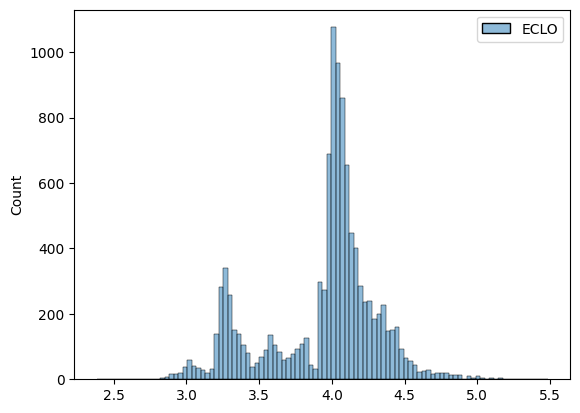

In [ ]:
# 예측값 그래프
sns.histplot(submission_df)

In [ ]:
# 구글드라이브에 저장
submission_df.to_csv('/content/drive/MyDrive/basemodel.csv', index=False)